# Best Practices

In this notebook, we provide best practices for using the <a href="https://visym.github.io/collector/pip_175k/">PIP-175k</a> dataset for training on <a href="https://mevadata.org">MEVA</a>.

In [1]:
import vipy
assert vipy.version.is_at_least('1.9.5')

In [2]:
V = vipy.util.load('/Users/jba3139/Desktop/pip_175k/valset.pkl')

## 1. Use framewise labels

This dataset uses multi-label activities with dense bounding box annotations.  Each object may be performing zero or more activities simultaneously, and the framewise labels capture when an object is performing an activity in a given frame.  This means that a person can be simutaneously be performing two or more activities such as "person_talks_on_phone" and "person_opens_facility_door".  This can also manifest due to the MEVA annotation definitions, which can introduce overlapping activities such as "vehicle_dropping_off" and "vehicle_stopping". 

We recommend using the framewise labels to export tubelets of deforming bounding boxes over time for training.  Examples of extracting labels and boxes from the toolchain are shown below.

In [3]:
v = V[1].mindim(512).load()   # load a single video from the dataset
print(v)   # Each video has useful information when printed

<vipy.video.scene: height=512, width=512, frames=223, color=rgb, filename="/Users/jba3139/Desktop/pip_175k/videos/car_drops_off_person/778838D5-92E0-49DB-B1C9-AEB05669D125-3542-00000294C2F31029_1.mp4", fps=30.0, category="car_drops_off_person", tracks=1, activities=3>


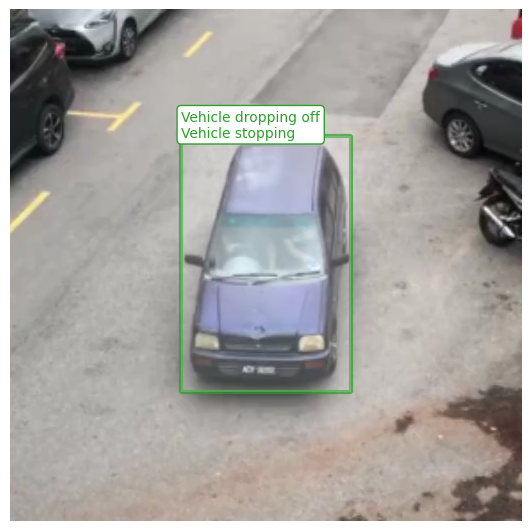

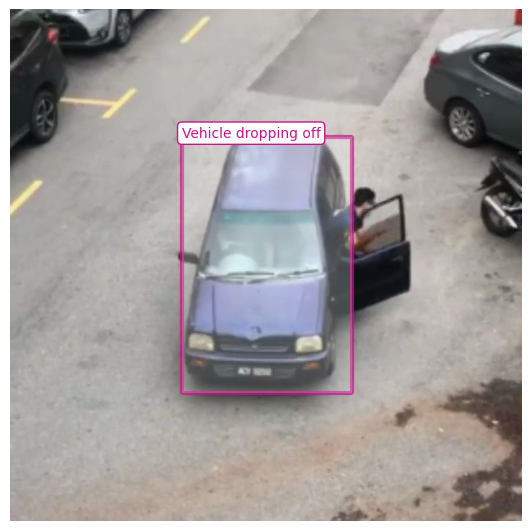

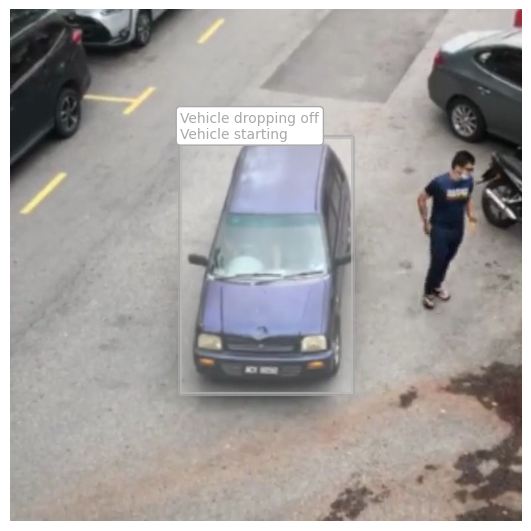

<vipy.image.scene: height=512, width=512, color=rgb, category="car_drops_off_person", objects=1>

In [4]:
v[0].show()   # show the first frame of video as an annotated image.  
v[100].show()   # 100th frame of video
v[200].show()   # 200th frame of video

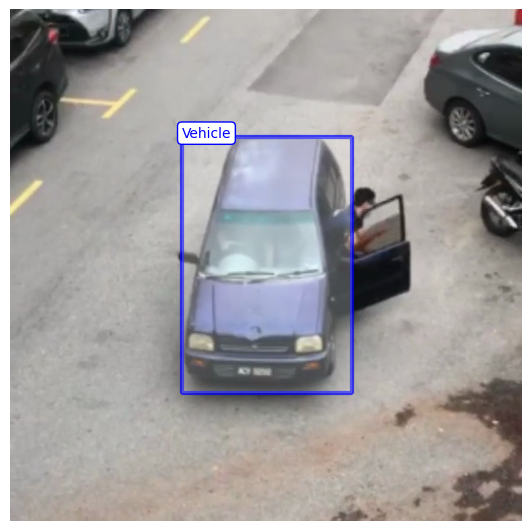

In [5]:
im = v[100][0].show()   # 100th frame, first object

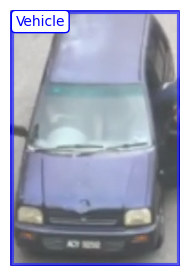

<vipy.image.imagedetection: height=256, width=170, color=rgb, category="Vehicle", bbox=(xmin=0.0, ymin=0.0, width=170.0, height=256.0)>

In [6]:
im.crop().show()  # crop this object using it's bounding box

In [7]:
im.boundingbox()   # return the bounding box for this object

<vipy.object.detection: category="Vehicle", bbox=(xmin=0.0, ymin=0.0, width=170.0, height=256.0)>

In [8]:
im.boundingbox().json()   # as JSON for portability

'{"_xmin":0,"_ymin":0,"_xmax":170,"_ymax":256,"_id":"2cb7abdc3f104dc5b660704c0b6c90fd","_label":"Vehicle","_shortlabel":"Vehicle","_confidence":null,"attributes":{"trackid":"f9991ee6ecac11ea82acac1f6b2c363c","activityid":["f9991bb2ecac11ea82acac1f6b2c363c"],"noun verb":[["Vehicle","dropping off"]]}}'

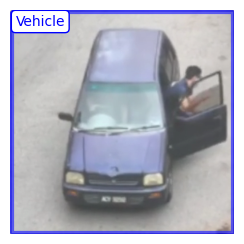

In [9]:
# make square, crop and resize to 224x224 
im = v[100][0].boxmap(lambda bb: bb.dilate(1.2).maxsquare()).crop().mindim(224).show()  

In [10]:
print(v.activitylabels(0))   # The labels in frame 0
print(v.activitylabels(100))  # in frame 100
print(v.activitylabels(200))  # in frame 200
lbls = [(k,lbl) for (k,lbl) in enumerate(v.label())]  # (frame index, label set) tuples

{'car_drops_off_person', 'car_stops'}
{'car_drops_off_person'}
{'car_drops_off_person', 'car_starts'}


## 2. Use a multi-label loss

The use of joint activity labels means that activities can occur simulataneously.  A single actor can be performing more than one activity at the same time, which means that a loss that assumes one-hot ground truth labels (e.g. categorical cross entropy) is an inappropriate choice for training.  Instead, we recommend a framewise mutli-label loss that can be trained with multiple simulataneous labels per frame (e.g. binary cross-entropy).   

## 3.  Use your object proposals
We recommend running your proposal generation pipeline on these videos to output your own object tracks for encoding the clips for training.  This will use the proper bounding box style for encoding tracks for representing activities.    

For example, the following code will run an object detector on each frame of video, and compute the intersection of the returned object detections with the ground truth using a greedy bounding box assignment based on bounding box intersection over union.  You can use the resulting annotated frame (e.g. imdet.objects()) as a replacement for the ground truth with your proposals.

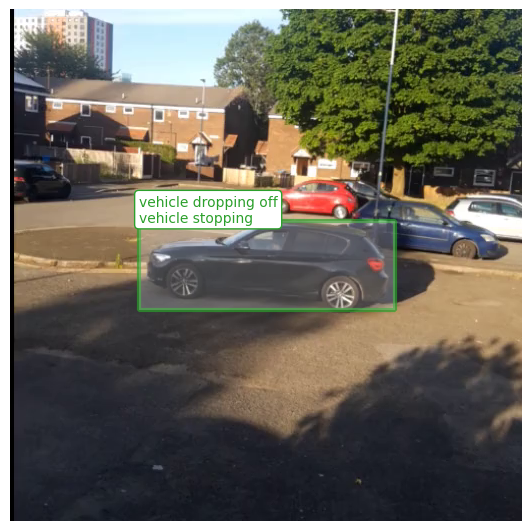

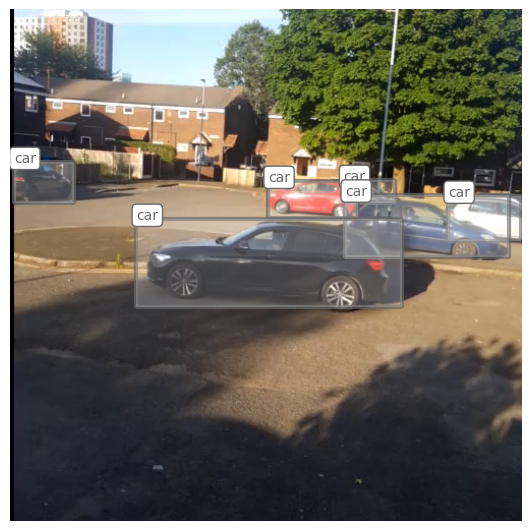

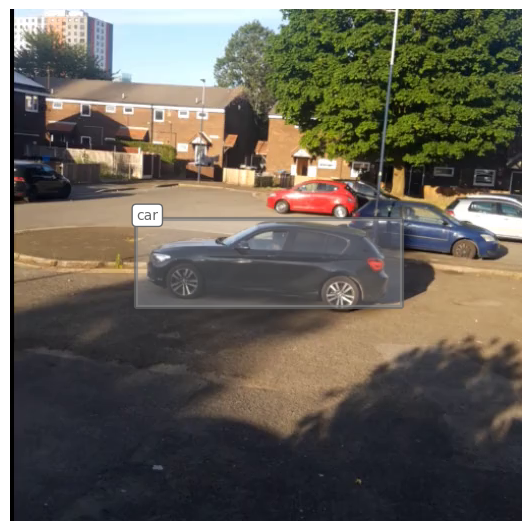

In [11]:
from pycollector.detection import ObjectDetector
detect = ObjectDetector()
for im in V[3].mindim(512).stream():
    im.show()                                  # the original labeled image
    imdet = detect(im).show()                  # the new detections
    imdet.intersection(im, miniou=0.8, bycategory=False).show()  # the best assignment of your detection to the truth (if any)
    break

## 4. Undo the MEVA Temporal Padding

The [MEVA annotation requirements](http://mevadata.org) includes class specific temporal padding which introduces up to five seconds of activity padding before and after activities occur.  In order to be strictly consistent with the MEVA annotation definitions, we have introduced the MEVA padding as a [post processing step](https://github.com/visym/collector/blob/master/pycollector/dataset.py#L27-L86).  However, this padding can introduce label errors during training due to background frames purposely mislabeled as the target class.  Furthermore, this padding may introduce overlapping disjoint activities (e.g. opening and closing simultaneously).  Our videos were collected with tight and disjoint temporal boundaries as determined by the collectors when the videos were recorded.  We recommend undoing the MEVA padding at training time, and labeling the padded frames as a framewise label to precisely localize the activities as determined by the annotator.  Then, the temporal padding may be re-introduced at test time.  Contact us at <info@visym.com> and we will provide you these precise framewise labels. 

## 5.  Use the Collector labels

Our collection platform includes additional labels that can aid in your training.  We subdivide broad classes into subclasses, which provide a more challenging task for training.  For example, we break out the broad class "person_puts_down_object" into "person_puts_down_object_on_shelf", "person_puts_down_object_on_floor" and "person_puts_down_object_on_table".  These are visually distinct activities, which can be rolled into a single class "person_puts_down_object", but we recommend using the sub-classes during training to reduce overfitting.  Then, at test time, the original MEVA labels can be used.

Also, the collection platform includes additional weak labels that can aid in your training.  These labels are stored as metadata for each video and include:

* *Collection name*.  This is the description of the collection that is given to the collectors.  
* *Collection date*.  This is the timestamp when the video was collected.  
* *Geolocation*.  This is the region of the world that the collection was recorded (with consent).
* *Collector ID*.  This is a unique identifier for the collector who recorded the video.  
* *Subject ID*.   This is a unique identifier for the consented subject who is in the video.  
* *Device ID*.  This is mobile OS (Android, iOS) and device type that was used to collect the original video.  
* *Framerate*.  This is the framerate at which the original video was collected.  

You can access this metadata as a dictionary or by casting a video to a [Collector](https://github.com/visym/collector) Video objects.

In [12]:
V[-1].metadata()

{'collection_id': 'b37f9ace-77ea-4659-8781-5e59176dcd25',
 'video_id': 'E0E65439-B009-4215-9F95-BA19BC6A5CD8',
 'ipAddress': '109.245.32.25',
 'duration': 10,
 'app_version': '1.0.22',
 'os_version': '13.6.1',
 'collection_name': 'Unload something from a rear door',
 'program_name': 'MEVA',
 'device_identifier': 'ios',
 'subject_ids': ['10559b39-25a9-44bb-b9fa-44d6eb2e96ab'],
 'device_type': 'iPhone6S',
 'frame_rate': 29.974859795010634,
 'frame_width': 1080,
 'collected_date': '2020-08-23 06:36:46',
 'collector_id': '2c4dd6fd-b71a-4850-a688-f3b7761835d4',
 'blurred_faces': 0,
 'project_name': 'MEVA Car',
 'frame_height': 1920,
 'project_id': '4c66a969-892c-4114-b711-45b2af02244a',
 'orientation': 'portrait',
 'rotate': None}

In [13]:
from pycollector.video import Video
v = Video.cast(V[-1])
print(v.geolocation())
print(v.uploaded())

{'ip': '109.245.32.25', 'host': '109.245.32.25', 'isp': 'Telenor d.o.o. Beograd', 'city': 'Belgrade', 'countrycode': 'RS', 'countryname': 'Serbia', 'latitude': '44.8166', 'longitude': '20.4721'}
2020-08-23 06:36:46-04:00


Our collections organize activities into groups to introduce diversity in the scene.  For example, we specify to the collectors to load and unload both from a trunk and from a rear door of a vehicle to help introduce intra-class diversity.  Also, we introduce joint activities such as "Leave this scene while talking on a phone". The full list of collection names are self explanatory and are available as follows.  Classes may be filtered to remove variants that may not reflect the target domain bias (e.g. motorcycle are not present in MEVA), or which do not satisfy the assumptions of the loss function (e.g. joint activities).  

In [14]:
print(set([v.metadata()['collection_name'] for v in V if 'collection_name' in v.metadata()]))

{'Greet a friend with a handshake while sitting', 'Hand something to your friend', 'Carry a heavy object while walking and put it down on the floor', 'Drive car turning around', 'Drive car turning right while starting', 'Come into a scene through an opening', 'Drive car turning right', 'Drive car turning left while stopping', 'Pick up, then walk and carry a heavy object', 'Talk while fidgeting', 'Walk and talk', 'Load something into a rear door', 'Walk while talking and texting on your phone', 'Steal something from your friend and walk away', 'Sit and read a document', 'Leave this scene through a closed door while talking on a phone', 'Pick up an object from a table and put it down on a high shelf', 'Greet a friend with a handshake then talk while standing', 'Pick up a document from a table and read', 'Come into this scene through a closed door', 'Put down a package on the table and walk away', 'Ride a Bicycle', 'Drive car backwards', 'Talk on phone and fidget', 'Read and fidget', 'Dri

## 6.  Use background stabilized videos

Our pipeline supports optical flow based stabilization of video.  This reduces the artfacts due to hand-held cameras to stabilize the background.  Remaining artifacts are due to non-planar scenes, rolling shutter distortion and subpixel optical flow correspondence errors.  *The stabilization is only valid within the tracked actor bounding box for small camera motions.  Large motions will introduce stabilization artifacts due to non-planar scene effects and should be filtered prior to usage.*  The stabilization artifacts will manifest as a slightly shifting background relative to the actor which may affect flow based methods.  

The pip-175k-stabilized release was constructed by running this stabilization on all videos and updating the object boxes accordingly.  You can run this yourself as shown below, or use the public release.  You can use the attribute "stabilize" to filter on the stabilziation residual to filter out those videos with too large a distortion.

[vipy.flow.stabilize]: Affine coarse to fine stabilization ...


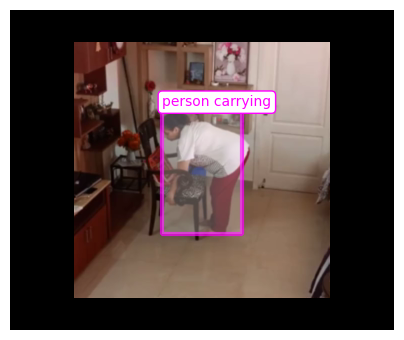

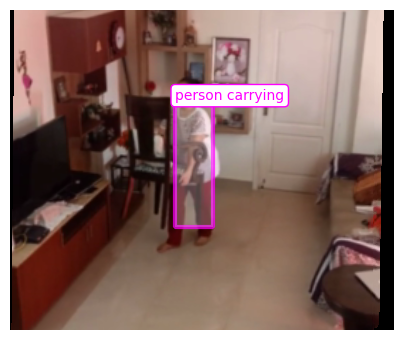

{'mean residual': 1.3057592780679719, 'median residual': 0.9582987531289169}


In [15]:
d = vipy.util.groupbyasdict(V, lambda v: v.category())
v = d['person_carries_heavy_object'][0].mindim(256).stabilize()
v.frame(0).show()
v.frame(150).show()
print(v.getattribute('stabilize'))   # the stabilization residual for filtering poorly stabilized videos

## 7. Export to your pipeline

You can export torch or numpy arrays, or just transcode your videos for native ingestion into your pipeline at the appropriate frame size.


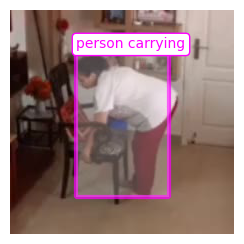

[vipy.video.annotate]: Annotating video ...


In [16]:
d = vipy.util.groupbyasdict(V, lambda v: v.category())
v = d['person_carries_heavy_object'][0]
v = v.crop(v.trackbox().dilate(1.5).maxsquare()).mindim(224).saveas('/tmp/out.mp4')
v.thumbnail(frame=0).show()
v.show(notebook=True)

In [17]:
v.torch().shape    # export the transcoded video as a torch tensor

torch.Size([282, 3, 224, 224])

In [18]:
v.json()    # Export the metadata as a JSON encoded string

/Users/jba3139/dev/vipy/vipy/video.py:423: UserWarning: JSON serialization of video requires flushed buffers, will not include the loaded video.  Try store()/restore()/unstore() instead to serialize videos as standalone objects efficiently.
  warnings.warn("JSON serialization of video requires flushed buffers, will not include the loaded video.  Try store()/restore()/unstore() instead to serialize videos as standalone objects efficiently.")


'{"_filename":"\\/tmp\\/out.mp4","_url":null,"_framerate":30,"_array":null,"_colorspace":"rgb","attributes":{"blurred_faces":0,"collected_date":"2020-05-06 15:27:25","collection_id":"P004C006","collector_id":"533e5fb295","device_identifier":"android","device_type":"CPH1969","duration":16,"frame_height":1920,"frame_rate":30.0,"frame_width":1080,"orientation":"portrait","os_version":"28","project_id":"P004","subject_ids":["20200506_1527244575402164829910826"],"video_id":"20200506_1527244575402164829910826","rotate":null},"_startframe":null,"_endframe":null,"_endsec":null,"_startsec":null,"_ffmpeg":"ffmpeg -i \\/tmp\\/out.mp4 dummyfile","_category":"person_carries_heavy_object","_tracks":{"c3005754eb9011ea9217ac1f6b2c363c":{"_id":"c3005754eb9011ea9217ac1f6b2c363c","_label":"person","_shortlabel":"person","_framerate":null,"_interpolation":"linear","_boundary":"strict","attributes":{},"_keyframes":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,

We recommend that in addition to your planned training data augmentation, you introduce scale jittering.  The MEVA dataset includes many ultra-tiny people walking far from the camera.  The PIP dataset does not include these tiny people, but the scale variation can be introduced synthetically by downsampling the crops to an appropriate resolution to best match the target domain shift prior to training.  

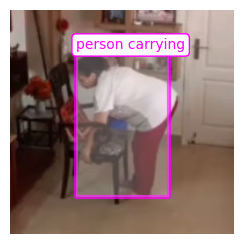

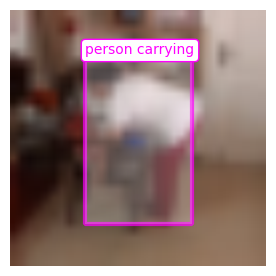

<vipy.image.scene: height=256, width=256, color=rgb, category="person_carries_heavy_object", objects=1>

In [19]:
v.thumbnail(frame=2).show().mindim(32).mindim(256).show()